In [1]:
# load the TensorBoard notebook extension
%load_ext tensorboard

### Imports

In [2]:
import cv2

In [3]:
import os 

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [4]:
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
import lightning as pl

from torchmetrics.functional import accuracy
from lightning.pytorch.callbacks import LearningRateMonitor

### Create the ISBI segmentation data set

We are using the ISBI image segmentation data set from http://brainiac2.mit.edu/isbi_challenge/ (with ground truth test labels extracted from here https://github.com/a-martyn/unet/tree/master/data/membrane/test/target so we don't have to upload to the competition to check how we are doing).

In [6]:
class SegmentationDataset(Dataset):
        
    def __init__(self, root_dir, transforms=None):
        
        self.ids  = os.listdir(root_dir + 'images/')
        self.imgs = [os.path.join(root_dir, 'images/', i) for i in self.ids]
        self.mask = [os.path.join(root_dir, 'masks/', i) for i in self.ids]
        
        self.transforms = transforms
                
    
    # get a single item from the data set
    def __getitem__(self, idx):
        
        # read image and mask data (both grayscale here)
        image = cv2.imread(self.imgs[idx], 0)
        masks = cv2.imread(self.mask[idx], 0)
        
        # make mask data either 0 or 1 (rather than 0 or 255)
        masks = masks // 255
        
        # note: in some use cases the pixel value of our mask might denote
        # the class value, so we'd have to remove the line above
        
        # store in our sample dictionary
        sample = {'image': image, 
                  'mask': masks}
        
        # apply any transforms
        if self.transforms:
            new = self.transforms(image=sample['image'], mask=sample['mask'])
            sample['image'] = new['image']
            sample['mask'] = new['mask']   
        
        return sample
    
    
    # get the length of the data set
    def __len__(self):
        return len(self.ids)

### Create an ISBI data module

This is based on the lightning data module and handles reading / preparing the dataset and creating the data loaders for training and validation.
See https://pytorch-lightning.readthedocs.io/en/latest/datamodules.html#lightningdatamodule-api

In [7]:
class ISBI_data_module(pl.LightningDataModule):
    
    def __init__(self,
                 data_dir: str = './data/',
                 batch_size: int = 2,
                 num_workers: int = 8):
        
        # what this does is make sure we call all the methods in the right 
        # order - see https://stackoverflow.com/a/27134600
        super().__init__()
        
        # specify where to save the data and how to load it (e.g. batch size, 
        # how many workers to use when loading the data, etc.)
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        # specify key information about the dataset
        self.dims = (1, 512, 512)
        self.num_classes = 1
        
        # initialise the specified default train and test transforms
        self._set_default_transforms()
        
    
    # get the data sets for train and val/test
    def setup(self, stage=None):
        
        # load the datasets :)
        self.train_dataset = SegmentationDataset(self.data_dir + 'train/', transforms=self.train_transform)
        self.test_dataset = SegmentationDataset(self.data_dir + 'test/', transforms=self.test_transform)
        
    
    # get the data loaders ...
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers)    
    
    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)    
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)    
        
    
    # set up the default training and testing transforms using albumentations - which
    # does a better job of image transforms for segmentation tasks
    def _set_default_transforms(self):       
         
        # for training we use elastic transformations and some shifting and rotations
        self.train_transform = A.Compose([
        
            # mess with the image scales (random crops, rotations, etc.)
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0.25, shift_limit=0.1, p=1, border_mode=0),
            A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
            A.RandomCrop(height=512, width=512, always_apply=True),

            A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            
            # probably should apply contrast adjustment to the image also ...

            # normalise the image and convert both image and mask to tensors
            A.Normalize(mean=(0), std=(1)),
            A.pytorch.ToTensorV2()
        ])

        # for the test data we just convert to a tensor (which also rescales to 0 - 1)
        self.test_transform = A.Compose([
            A.PadIfNeeded(512, 512),
            
            # normalise the image and convert both image and mask to tensors
            A.Normalize(mean=(0), std=(1)),
            A.pytorch.ToTensorV2()
        ])  

### Test the data module

Let's grab an image out of the data module to see what it lloks like.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# helper function for data visualisation
def visualize(**images):
    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        
        # display in grayscle because our ISBI data is grayscale
        plt.imshow(image, cmap='gray')
        
    plt.show()

In [9]:
batch_size = 2
test_data = ISBI_data_module(data_dir='./data/isbi_segmentation_dataset/', batch_size=batch_size)
test_data.setup()

test_batch = next(iter(test_data.train_dataloader()))

/tmp/ipykernel_61649/1076855349.py:58: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),


In [10]:
print(test_batch['mask'].shape)

torch.Size([2, 512, 512])


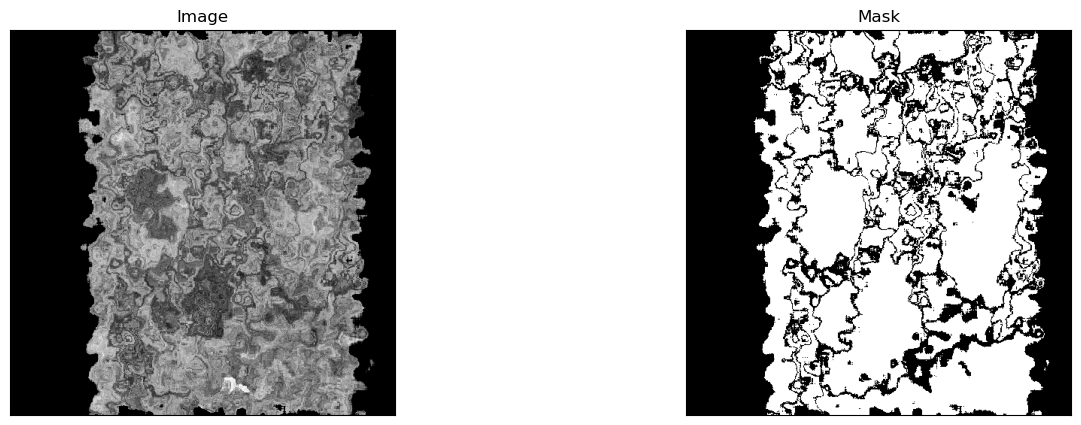

In [11]:
visualize(image=test_batch['image'].squeeze()[0], mask=test_batch['mask'].squeeze()[0])

In [12]:
print(np.unique(test_batch['mask'].squeeze()[0]))

[0 1]


In [13]:
print(test_batch['mask'][0].shape)

torch.Size([512, 512])


### Get the UNet model and wrap it in a lightning module

I'm wrapping my version of the UNet model in a lightning module so we can use pytorch-lightning for training.
See: https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.core.lightning.html#module-pytorch_lightning.core.lightning

In [14]:
from unet_model import UNet

In [17]:
class LightningUNet(pl.LightningModule):
    
    def __init__(self, batch_size=2, lr=1e-4):
        super().__init__()
        self.batch_size = batch_size
        self.save_hyperparameters()
        self.model = UNet(num_classes=2,
                          enc_channels=[1, 64, 128, 256, 512, 1024],
                          dec_channels=[1024, 512, 256, 128, 64])
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch['image'], batch['mask']
        
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat.squeeze(), y.squeeze().long())
        self.log('train_loss', loss)
        return loss

    def evaluate(self, batch, stage=None):
        
        x, y = batch['image'], batch['mask']      
        y_hat = self.forward(x)
        
        loss = F.cross_entropy(y_hat.squeeze(), y.squeeze().long())
        
        preds = torch.argmax(y_hat.squeeze(), dim=1)
        acc = accuracy(preds, y, task='binary')

        if stage:
            self.log(f'{stage}_loss', loss, prog_bar=True)
            self.log(f'{stage}_acc', acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, 'val')

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, 'test')

    # set up the optimisers
    def configure_optimizers(self):
                
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)        
        
        scheduler_dict = {
            'scheduler': ReduceLROnPlateau(optimizer, patience=1),
            'monitor': 'val_loss'
        }
        return {'optimizer': optimizer, 'lr_scheduler': scheduler_dict}
        

In [18]:
batch_size = 2

data = ISBI_data_module(data_dir='./data/isbi_segmentation_dataset/', batch_size=batch_size)

model = LightningUNet(batch_size=batch_size, lr=1e-4)
model.datamodule = data

trainer = pl.Trainer(
    max_epochs=40,
    accelerator="gpu",
    logger=pl.pytorch.loggers.TensorBoardLogger('lightning_logs/', name='unet'),
    callbacks=[LearningRateMonitor(logging_interval='step')],
)

trainer.fit(model, data)
trainer.test(model, datamodule=data);

/tmp/ipykernel_61649/1076855349.py:58: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 31.0 M | train
---------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.123   Total estimated model params size (MB)
48        Modules in train mode
0         Modules in eval mode


/home/alex/code/development_tools/anaconda3/envs/lightning-segmentation/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|███████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.11it/s, v_num=4]
Validation: |                                                                           | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████████| 15/15 [00:03<00:00,  4.75it/s, v_num=4, val_loss=0.612, val_acc=0.797]
Validation: |                                                                           | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████████| 15/15 [00:03<00:00,  4.68it/s, v_num=4, val_loss=0.495, val_acc=0.797]
Validation: |                                                                           | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|████████████████████████| 15/15 [00:03<00:00,  4.64it/s, v_num=4, val_loss=0.446, val_acc=0.797]
Validation: |                                                                           | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|████████████████████████| 15/15 [00:03<00:00,  4.68it/s, v_num=4, val_loss=0.381, val_acc=0.807]
V

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|███████████████████████| 15/15 [00:05<00:00,  2.68it/s, v_num=4, val_loss=0.298, val_acc=0.864]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8644940853118896
        test_loss           0.29819315671920776
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Let's see if we can test on an image

In [19]:
batch_size = 2
test_data = ISBI_data_module(data_dir='./data/isbi_segmentation_dataset/', batch_size=batch_size)
test_data.setup()
test_batch = next(iter(test_data.test_dataloader()))

/tmp/ipykernel_61649/1076855349.py:58: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),


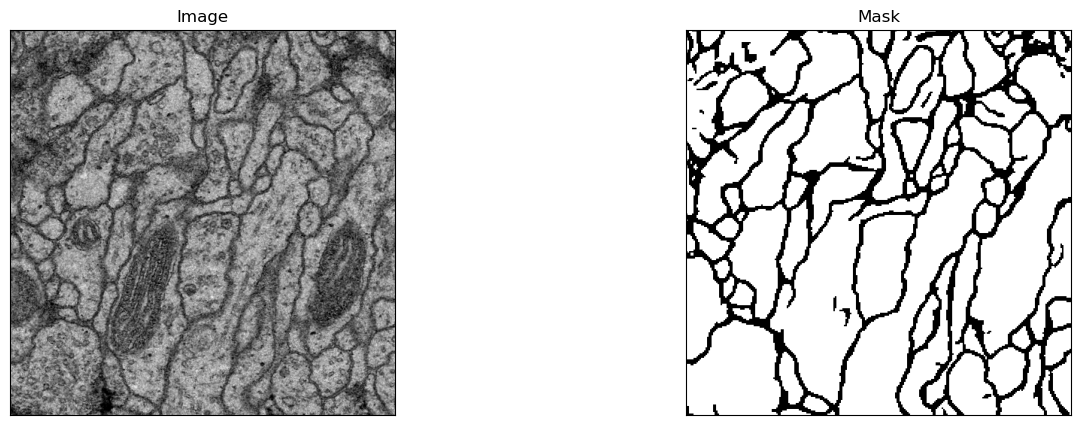

In [20]:
visualize(image=test_batch['image'][0].squeeze(), mask=test_batch['mask'][0].squeeze())

In [23]:
pred = model(test_batch['image'])

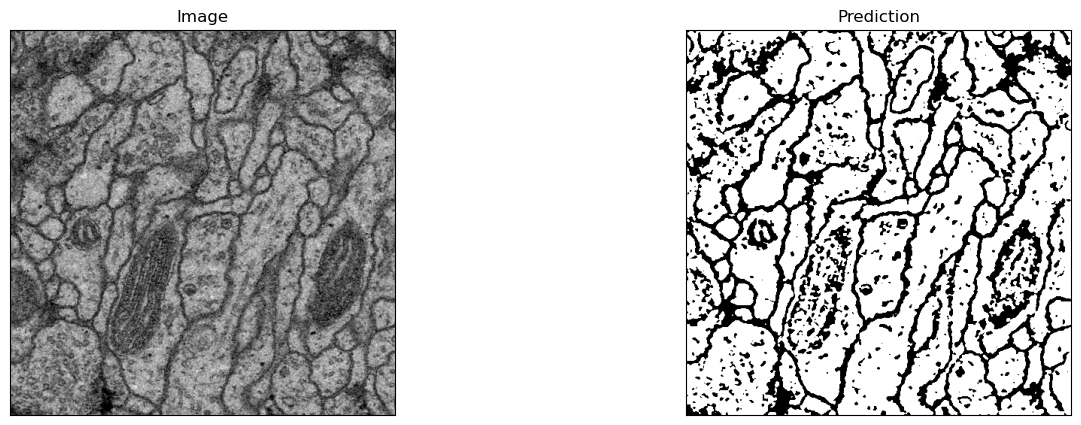

In [24]:
predicted_mask = torch.argmax(pred.squeeze(), dim=1).cpu().detach().numpy()
visualize(image=test_batch['image'][0].squeeze(), prediction=predicted_mask[0].squeeze())

### Testing data loaders

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

ts = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
tl = torch.utils.data.DataLoader(ts, batch_size=4, shuffle=True, num_workers=2)

test_batch = next(iter(tl))

In [ ]:
print(len(test_batch))